# Implementation LSTM model for Forecasting

In [302]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [303]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## DATA INGESTION

In [304]:
# Input simbol saham
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2023, 1, 1)
end_date = date(2024, 1, 1)

data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [305]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,4910.0,4920.0,4820.0,4870.0,4349.535645,100200100
2023-01-03,4830.0,4900.0,4830.0,4850.0,4331.673340,95136500
2023-01-04,4850.0,4850.0,4770.0,4770.0,4260.223145,188071000
2023-01-05,4750.0,4760.0,4570.0,4640.0,4144.116211,292142000
2023-01-06,4550.0,4640.0,4550.0,4620.0,4126.253418,175932000


In [306]:
data.reset_index(inplace=True)

input_feat = input("Input feature yang akan digunakan (e.g: Open, High, Low, Close, Adj Close, Volume): ")
data = data[["Date", input_feat]]
print(data.shape)
data

(239, 2)


,Date,Close
0,2023-01-02,4870.0
1,2023-01-03,4850.0
2,2023-01-04,4770.0
3,2023-01-05,4640.0
4,2023-01-06,4620.0
...,...,...
234,2023-12-21,5575.0
235,2023-12-22,5675.0
236,2023-12-27,5625.0
237,2023-12-28,5725.0


## DATA PROCESSING

In [307]:
# scaling feature
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

# print(scaled_data)

In [308]:
# Pembagian data menjadi data training dan data testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

# print(train_data)
# print(train_data.shape)

# print(train_size)
# print(train_size.shape)

In [309]:
# Persiapan data untuk model LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [310]:
tf.random.set_seed(7)

In [311]:
sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Modelling

In [312]:
# model LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 1, 128)            66560     
                                                                 
 dropout_62 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_63 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_63 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_64 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_64 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)               

# Training

In [313]:
optimizer = Adam(learning_rate=0.005)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
model_final = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[ early_stopping], validation_data=(X_test, y_test))

Epoch 1/100
3/3 - 5s - loss: 0.3912 - mean_absolute_error: 0.5641 - val_loss: 0.3964 - val_mean_absolute_error: 0.6099 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.2974 - mean_absolute_error: 0.4792 - val_loss: 0.2469 - val_mean_absolute_error: 0.4749 - 142ms/epoch - 47ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1551 - mean_absolute_error: 0.3252 - val_loss: 0.0541 - val_mean_absolute_error: 0.2049 - 139ms/epoch - 46ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0512 - mean_absolute_error: 0.1906 - val_loss: 0.0505 - val_mean_absolute_error: 0.2085 - 119ms/epoch - 40ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0877 - mean_absolute_error: 0.2625 - val_loss: 0.0201 - val_mean_absolute_error: 0.1182 - 90ms/epoch - 30ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0411 - mean_absolute_error: 0.1639 - val_loss: 0.0209 - val_mean_absolute_error: 0.1190 - 91ms/epoch - 30ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0467 - mean_absolute_error: 0.1842 - val_loss: 0.0464 - val_mean_absolute_error: 0.1866 - 92ms/epoch - 31m

# Evaluation

In [314]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
round_loss = [round(num, 5) for num in loss]
print("Loss :", round_loss)

predict = model.predict(X_test)

2/2 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0488
Loss : [0.00442, 0.04881]


2/2 [==============================] - 1s 14ms/step


In [315]:
print("-"*15, " Metric ","-"*15)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

---------------  Metric  ---------------
RMSE :  0.06646
MSE  :  0.00442
MAE  :  0.04881


# Visualization

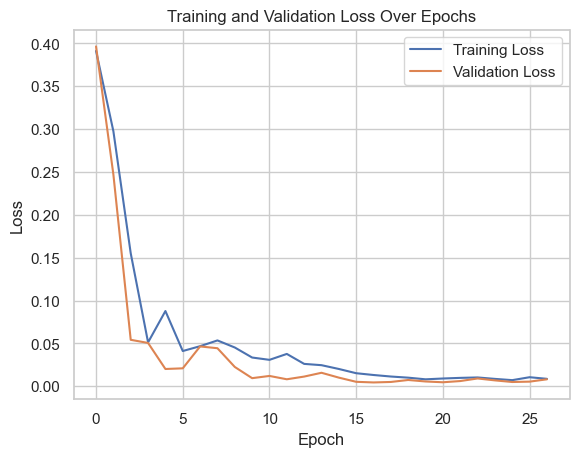

In [316]:
# Plot loss
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Saving Model

In [317]:
import time

ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
print("Success saving model!")

INFO:tensorflow:Assets written to: ../lstm_stock/1713727851/assets


INFO:tensorflow:Assets written to: ../lstm_stock/1713727851/assets


Success saving model!
